In [1]:
#Standard fastai imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
np.random.seed(11)

In [2]:
# assigning a path makes it easier when working on other machines with different data locations
path = Path('data')

In [3]:
df = pd.read_csv(path/'full.csv')
path_img = path/'ISIC_2019_Training_Input'

In [4]:
# add flip vert in addition to standard fastai transforms
tfms = get_transforms(flip_vert=True)

Here it may be okay to add flip_vert to the standard transforms. Want to be able to diagnose images from any angle.

In [5]:
# grab the train/val indexs
train_idx = df[df['is_val']==0].index
val_idx = df[df['is_val']==1].index

Next create a databunch. First we will train on smaller image sizes so we can reduce training time. Later we can retrain the same model on larger image sizes.

In [6]:
# create the data source
src = (ImageList.from_csv(path_img, '../full.csv',suffix='.jpg')
                .split_by_idxs(train_idx,val_idx)
                .label_from_df(cols=1))

# create databunch
data = (src.transform(tfms, size=128)
            .databunch(bs=256)).normalize(imagenet_stats)

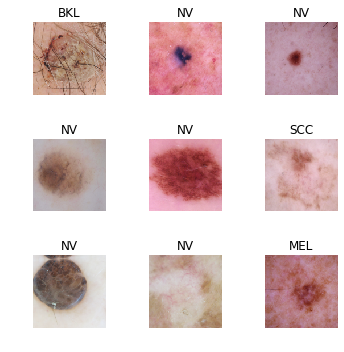

In [7]:
data.show_batch(3, figsize=(5,5))

In [8]:
data.classes

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

In [9]:
# check class balance
df.diagnosis.value_counts()

NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: diagnosis, dtype: int64

In [10]:
# weight decay will help with regularization
# to_fp16 will perform some operations in fp16 instead of 32. Lets model use less memory
learn = cnn_learner(data, models.resnet50,
                    metrics=[error_rate], wd=1e-1).to_fp16()

In [11]:
# set weights for loss function
w = torch.FloatTensor([10000/df.diagnosis.value_counts()['AK'],
                  10000/df.diagnosis.value_counts()['BCC'],
                 10000/df.diagnosis.value_counts()['BKL'],
                 10000/df.diagnosis.value_counts()['DF'],
                 10000/df.diagnosis.value_counts()['MEL'],
                 10000/df.diagnosis.value_counts()['NV'],
                 10000/df.diagnosis.value_counts()['SCC'],
                 10000/df.diagnosis.value_counts()['VASC']]).cuda()

In [12]:
learn.loss_func = nn.CrossEntropyLoss(weight=w)

The class weightings helped improve the model a little bit compared to no class weights.

Model will be trained using one cycle learning from Leslie Smith <https://arxiv.org/abs/1803.09820>. A good blog post about it by Sylvain Gugger can be found here: <https://sgugger.github.io/the-1cycle-policy.html>. This helps the model train faster and take a lot of the guess work out of finding optimal learning rates.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


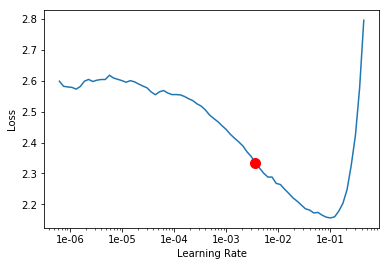

In [13]:
# part of the one-cycle learning 
# helps find a good learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

It's still worth trying different learning rates. Usually 1e-1 lower than the lower point in the chart above, or areas of the steepest decent in the plot work well.

In [14]:
lr = 3e-3
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.804138,1.441521,0.485472,02:21
1,1.391836,1.290440,0.427831,02:19
2,1.157941,1.178097,0.409141,02:18
3,1.008225,1.146281,0.387467,02:19
4,0.909006,1.111961,0.382912,02:18


In [15]:
learn.save('res50-1-sz128')

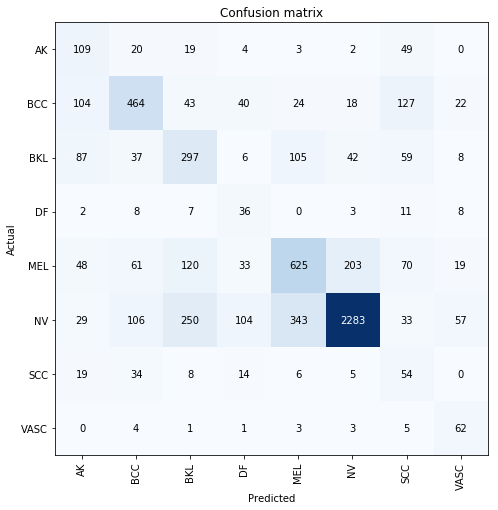

In [16]:
# plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


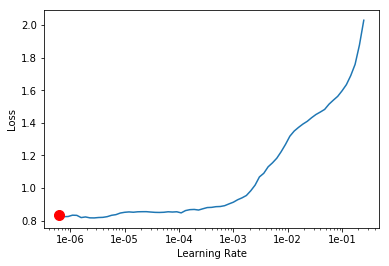

In [17]:
# unfreeze model
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

Instead of fine tuning by unfreezing a layer and then training the model layer by layer, instead we can unfreeze the entire model and use discriminative learning rates. The early layers in the model will have very low learning rates becuase we want to preserve the features the pretrained model already has. The further layers will have higher learning rates to fine tune the model on the skin classification problem. 

The above plot is used to find the lower learning rate for the earlier layers.

In [18]:
# max_lr=slice() lets us use discriminative learning rates,
# the earlier layers will have much lower learning rates
learn.fit_one_cycle(5, max_lr=slice(1e-7,lr/10))

epoch,train_loss,valid_loss,error_rate,time
0,0.856798,1.119477,0.380713,02:17
1,0.837437,1.138152,0.378357,02:17
2,0.805141,1.137506,0.370818,02:17
3,0.788178,1.135053,0.372232,02:17
4,0.765997,1.129925,0.366106,02:17


In [19]:
learn.save('res50-2-sz128')

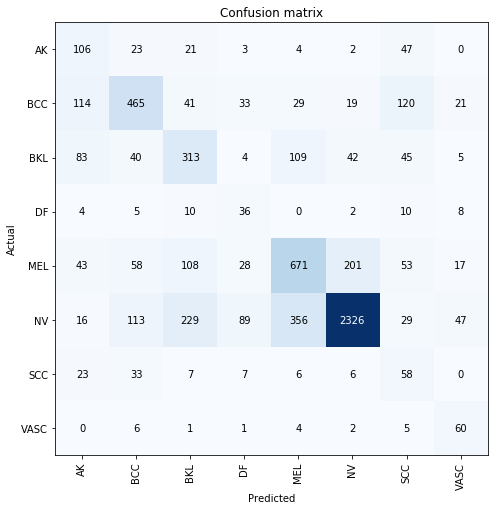

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

The model still clearly struggles. Next things to try:

- Train on larger image sizes
- Use a larger resnet
- Try other pretrained image classification models
- Try other class weightings, or try upsampling/downsampling to deal with class imbalance
- Try other data augmentations outside of standard fastai transforms
- Train the model over a 5 fold cv and average the 5 model ouputs for competition submission